In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import seaborn as sns

# Importing all the Dataframes

In [2]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')
tags_df = pd.read_csv('ml-latest-small/tags.csv')

# Exploratory Data Analysis

In [3]:
for df in [ratings_df, movies_df, tags_df]:
    display(df.head())
    print("*"*100)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


****************************************************************************************************


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


****************************************************************************************************


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


****************************************************************************************************


In [4]:
print("Unique users: ", ratings_df.userId.nunique())
print("Unique movies: ", ratings_df.movieId.nunique())
print("Average rating: ", ratings_df.rating.mean())
print("Average rating per user: ", ratings_df.groupby('userId').rating.mean().mean())
print("Average rating per movie: ", ratings_df.groupby('movieId').rating.mean().mean())

Unique users:  610
Unique movies:  9724
Average rating:  3.501556983616962
Average rating per user:  3.6572223377474
Average rating per movie:  3.262448274810963


#### Number of movies per rating

<Axes: >

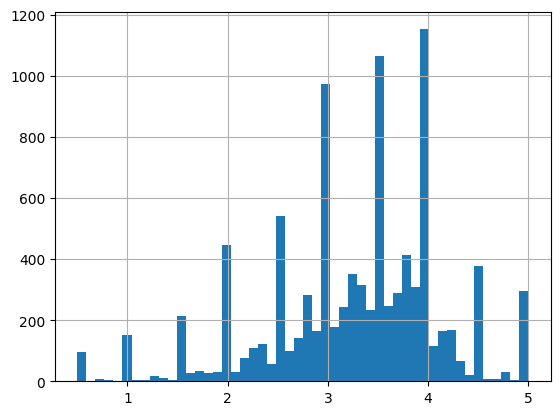

In [5]:
# Number of movies per rating
ratings_df.groupby('movieId').rating.mean().hist(bins=50)

In [6]:
# Calculate mean, count, and Bayesian average for each movie
ratings_count = ratings_df.groupby('movieId').rating.count()
ratings_mean = ratings_df.groupby('movieId').rating.mean()
C = ratings_mean.mean()
m = ratings_count.quantile(0.5)
bayesian_avg = ((ratings_count * ratings_mean) + (m * C)) / (ratings_count + m)

# Create a DataFrame with mean, count, and Bayesian average
movie_stats = pd.DataFrame({'mean_rating': ratings_mean, 'count': ratings_count, 'bayesian_avg': bayesian_avg})

# Merge with movies_df to include movie details
movie_stats = pd.merge(movie_stats, movies_df, on='movieId')

# Sort by Bayesian average in ascending order
lowest_rated = movie_stats.sort_values('bayesian_avg', ascending=True)
display(lowest_rated.head(10))

# Sort by Bayesian average in descending order
highest_rated = movie_stats.sort_values('bayesian_avg', ascending=False)
display(highest_rated.head(10))

,movieId,mean_rating,count,bayesian_avg,title,genres
5170,8387,0.800000,5,1.723418,Police Academy: Mission to Moscow (1994),Comedy|Crime
3799,5323,1.187500,8,1.753395,Jason X (2002),Horror|Sci-Fi|Thriller
1311,1760,1.350000,10,1.791334,Spice World (1997),Comedy
5260,8666,1.333333,9,1.815612,Catwoman (2004),Action|Crime|Fantasy
2821,3774,0.750000,4,1.826764,House Party 2 (1991),Comedy|Drama|Romance
1172,1556,1.605263,19,1.831243,Speed 2: Cruise Control (1997),Action|Romance|Thriller
2104,2799,1.312500,8,1.844304,Problem Child 2 (1991),Comedy
2679,3593,1.657895,19,1.876697,Battlefield Earth (2000),Action|Sci-Fi
271,312,1.444444,9,1.898945,Stuart Saves His Family (1995),Comedy
2103,2798,1.583333,12,1.919156,Problem Child (1990),Children|Comedy


,movieId,mean_rating,count,bayesian_avg,title,genres
277,318,4.429022,317,4.418085,"Shawshank Redemption, The (1994)",Crime|Drama
9600,177593,4.750000,8,4.344304,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
840,1104,4.475000,20,4.316841,"Streetcar Named Desire, A (1951)",Drama
796,1041,4.590909,11,4.306239,Secrets & Lies (1996),Drama
4390,6460,4.900000,5,4.285918,"Trial, The (Procès, Le) (1962)",Drama
882,1178,4.541667,12,4.285823,Paths of Glory (1957),Drama|War
659,858,4.289062,192,4.273268,"Godfather, The (1972)",Crime|Drama
2579,3451,4.545455,11,4.270525,Guess Who's Coming to Dinner (1967),Drama
2224,2959,4.272936,218,4.259219,Fight Club (1999),Action|Crime|Drama|Thriller
917,1217,4.433333,15,4.238186,Ran (1985),Drama|War


#### Making Grenes by count Dataframe

In [7]:
# sepearate the genres
movies_df['genres'] = movies_df.genres.str.split('|')
# genres_df = genres_df.rename(columns=lambda x: f'genre_{x+1}')
# genres_df = genres_df.fillna('')
movies_df.head()

# list of all genres
genres = []
for genre in movies_df.genres:
    genres.extend(genre)
genres = set(genres)
print(genres)

# list of all genres with number of movies
genres_count = {}
for genre in genres:
    genres_count[genre] = 0
for genre in movies_df.genres:
    for g in genre:
        genres_count[g] += 1
print(genres_count)


# genre count df
genres_df = pd.DataFrame.from_dict(genres_count, orient='index', columns=['count'])
genres_df = genres_df.reset_index().rename(columns={'index': 'genre'})
genres_df = genres_df.sort_values('count', ascending=False)
genres_df.head()

{'Western', 'Romance', 'Sci-Fi', 'IMAX', 'Drama', 'Fantasy', 'Children', 'War', 'Animation', 'Documentary', 'Comedy', 'Mystery', 'Film-Noir', 'Musical', 'Horror', 'Thriller', 'Crime', '(no genres listed)', 'Adventure', 'Action'}
{'Western': 167, 'Romance': 1596, 'Sci-Fi': 980, 'IMAX': 158, 'Drama': 4361, 'Fantasy': 779, 'Children': 664, 'War': 382, 'Animation': 611, 'Documentary': 440, 'Comedy': 3756, 'Mystery': 573, 'Film-Noir': 87, 'Musical': 334, 'Horror': 978, 'Thriller': 1894, 'Crime': 1199, '(no genres listed)': 34, 'Adventure': 1263, 'Action': 1828}


,genre,count
4,Drama,4361
10,Comedy,3756
15,Thriller,1894
19,Action,1828
1,Romance,1596


#### Genres by count

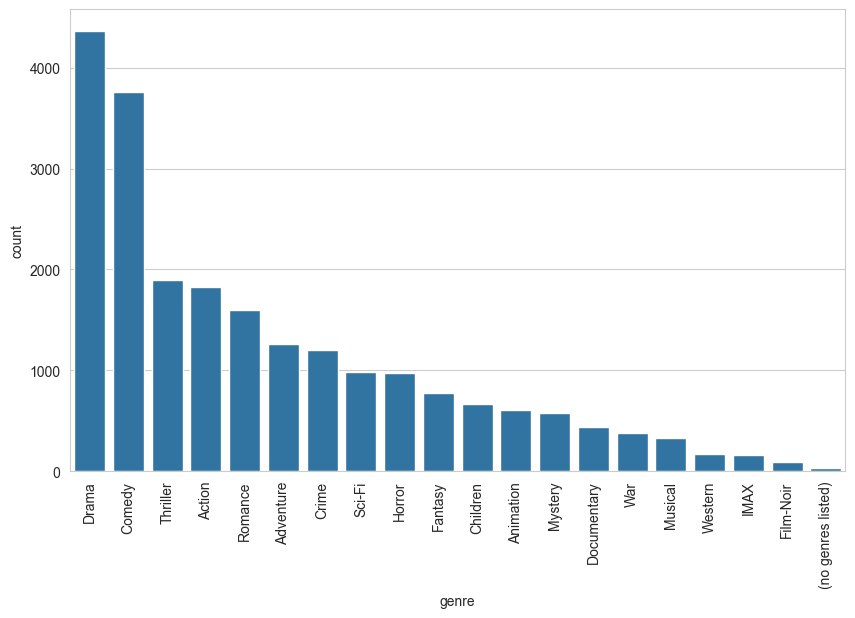

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='genre', y='count', data=genres_df)
plt.xticks(rotation=90)
plt.show()


In [9]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings_df)

In [10]:
# evaluate the sparsity of X
def calculate_sparsity(X):
    """
    This function calculates sparsity percentage of a matrix.
    
    Args:
        X: rating matrix
    
    Returns:
        sparsity: a float number between 0 and 1 representing the sparsity percentage
    """
    sparsity = float(len(X.nonzero()[0]))
    sparsity /= (X.shape[0] * X.shape[1])
    sparsity *= 100
    return sparsity

calculate_sparsity(X)


1.6999683055613624

In [11]:
# Get most active users and number of ratings
print("Number of movies most active user rated", X.getnnz(axis=1).max())
print("Number of movies least active user rated", X.getnnz(axis=1).min())

print("Most active user", X.getnnz(axis=1).argmax())
print("Lest active user", X.getnnz(axis=1).argmin())


# most rated movies
print("Number of ratings most rated movie got", X.getnnz(axis=0).max())
print("Number of ratings least rated movie got", X.getnnz(axis=0).min())

Number of movies most active user rated 2698
Number of movies least active user rated 20
Most active user 413
Lest active user 52
Number of ratings most rated movie got 329
Number of ratings least rated movie got 1


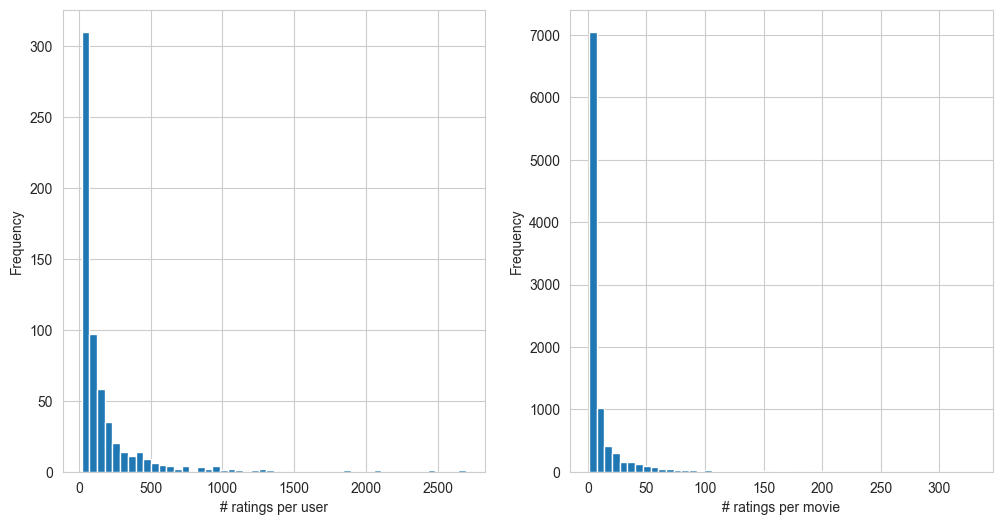

In [12]:
# plot number of ratings per user
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X.getnnz(axis=1), bins=50)
plt.xlabel('# ratings per user')
plt.ylabel('Frequency')

# plot number of ratings per movie
plt.subplot(1, 2, 2)
plt.hist(X.getnnz(axis=0), bins=50)
plt.xlabel('# ratings per movie')
plt.ylabel('Frequency')
plt.show()


#### Recommendations with k-Nearest Neighbors

In [13]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [14]:
movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
